In [1]:
# Hacky way to import from parent directory
# https://www.reddit.com/r/learnpython/comments/x6nibz/comment/in7rxzu/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button
import sys
sys.path.append('..')

In [2]:
from ebirdtools import EBirdTools
# San Jose
data_sj = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-26-00_37.33_-121.86_30_50.csv').sample(frac=0.2)
# Everglades (Florida). This file is small so it's ok to load more.
data_eg = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-31-45_25.75_-80.56_30_50.csv').sample(frac=1.0)
# Chicago
data_ch = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-35-54_41.88_-87.63_30_50.csv').sample(frac=0.2)
# Los Angeles
data_la = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-40-54_34.05_-118.24_30_50.csv').sample(frac=0.2)
# Seattle
data_se = EBirdTools.load_data('../data/ebd_alt_2025-08-20-20-44-54_47.61_-122.33_30_50.csv').sample(frac=0.2)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import plotly.express as px
import seaborn as sns

In [4]:
def plots(df, plot_px, plot_sns):
    if plot_px:
        fig = px.scatter_mapbox(df, lat='lat', lon='lng', color='cluster', hover_name='comName')
        fig.update_mapboxes(style='open-street-map')
        fig.show()
    if plot_sns:
        fig = sns.scatterplot(df, x='lng', y='lat', hue='cluster')
        plt.show()

In [62]:
def label_clusters(df, plot_px=False, plot_sns=False):
    """
    Returns a copy of the input df with a new column
    specifying which cluster each row belongs to.
    """
    clustering = DBSCAN(eps=0.02,
                        min_samples=50).fit(df[['lat', 'lng', 'alt']])
    
    df_aug = df.copy()
    df_aug['cluster'] = pd.Series(clustering.labels_, index=df_aug.index)
    # DBSCAN uses labels of '-1' for points that are too noisy to cluster
    df_aug = df_aug[df_aug['cluster'] != -1]

    plots(df_aug, plot_px, plot_sns)
    
    return df_aug

In [64]:
# Pseudo-normalize the elevation column
lab_sj['alt'] = data_sj['elevation_meters'].apply(lambda x: x/1000)
lab_sj = label_clusters(lab_sj)
lab_sj['cluster'].value_counts()

cluster
1     10467
5     10301
8      1924
10     1843
14     1033
      ...  
11       51
63       51
58       50
13       50
69       45
Name: count, Length: 70, dtype: int64

In [66]:
# Pseudo-normalize the elevation column
lab_eg['alt'] = data_eg['elevation_meters'].apply(lambda x: x/1000)
lab_eg = label_clusters(lab_eg)
lab_eg['cluster'].value_counts()

cluster
1     4182
2     3236
18    1820
4     1369
11    1257
8     1155
0     1141
6      976
7      810
9      708
16     676
13     481
22     453
23     386
5      327
31     314
3      299
34     280
12     264
43     259
29     246
30     229
42     195
15     192
26     189
25     187
24     163
36     156
41     145
28     137
21     132
10     125
45     112
33     110
19     107
35      89
37      89
32      79
20      78
44      78
14      77
40      71
38      70
27      64
39      54
17      52
Name: count, dtype: int64

In [68]:
# Pseudo-normalize the elevation column
lab_ch['alt'] = data_ch['elevation_meters'].apply(lambda x: x/1000)
lab_ch = label_clusters(lab_ch)
lab_ch['cluster'].value_counts()

cluster
0     5335
5     1038
14     628
4      619
6      558
      ... 
53      41
59      41
58      40
57      25
56      11
Name: count, Length: 62, dtype: int64

In [70]:
# Pseudo-normalize the elevation column
lab_la['alt'] = data_la['elevation_meters'].apply(lambda x: x/1000)
lab_la = label_clusters(lab_la)
lab_la['cluster'].value_counts()

cluster
2     5289
5     1561
18     983
12     956
3      758
      ... 
61      52
72      51
59      51
62      50
73      50
Name: count, Length: 74, dtype: int64

In [72]:
# Pseudo-normalize the elevation column
lab_se['alt'] = data_se['elevation_meters'].apply(lambda x: x/1000)
lab_se = label_clusters(lab_se)
lab_se['cluster'].value_counts()

cluster
9     1384
3      729
14     449
11     447
21     439
      ... 
28      50
83      50
40      50
80      50
86      50
Name: count, Length: 89, dtype: int64

In [11]:
def species_per_cluster(df, by='comName'):
    """
    Takes a df and returns a dict:
        Key: Cluster number
        Val: set of names found in the cluster
    """
    species = {}
    for i in pd.unique(df['cluster']):
        names = set(df[df['cluster'] == i][by])
        species[i] = names
    return species

In [12]:
def get_similarity(df_a, df_b):
    """
    Gets cluster similarity by calculating the set
    similarity of the species names found in each cluster.
    """
    output = []
    sp_a = species_per_cluster(df_a)
    sp_b = species_per_cluster(df_b)
    for k_a, v_a in sp_a.items():
        for k_b, v_b in sp_b.items():
            iou = len(v_a.intersection(v_b)) / len(v_a.union(v_b))
            d = {'A': k_a, 'B': k_b, 'iou': iou}
            output.append(d)
    return pd.DataFrame(output)

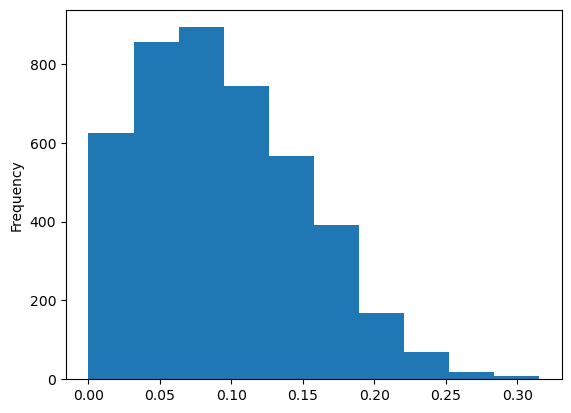

In [74]:
cluster_similarities = get_similarity(
    lab_sj,
    lab_ch
)
_ = cluster_similarities['iou'].plot.hist()

In [76]:
def foo(name, df_src, df_tgt, do_plots=False):
    if name not in df_src['comName'].values:
        raise KeyError('Unable to find species in the source region.')
    print('Is bird already found in the target region?', name in df_tgt['comName'].values)
    
    # find which source clusters the named species occurs in
    src_clusters = np.unique(df_src[df_src['comName'] == name]['cluster'])
    # drop the clusters that the named species doesn't occur in
    df_srcdrop = df_src[df_src['cluster'].isin(src_clusters)]
    # compare species sets
    sims = get_similarity(df_srcdrop, df_tgt)
    
    s_mean = sims['iou'].mean()
    s_std = sims['iou'].std()
    s_max = sims['iou'].max()
    s_z = (s_max - s_mean) / s_std
    a = sims[sims['iou'] == s_max]['A'].item()
    b = sims[sims['iou'] == s_max]['B'].item()
    print('Sub-cluster compatability:', round(s_mean, 2))
    print('Highest similarity:', round(s_max, 2), f'(z {round(s_z, 2)})')

    sightings_a = df_src['cluster'].value_counts()
    sa_mean = sightings_a.mean()
    sa_std = sightings_a.std()
    sa_z = (sightings_a[a] - sa_mean) / sa_std
    print('Source cluster:', a, f'(num sightings z {round(sa_z, 2)})')
    sightings_b = df_tgt['cluster'].value_counts()
    sb_mean = sightings_b.mean()
    sb_std = sightings_b.std()
    sb_z = (sightings_b[b] - sb_mean) / sb_std
    print('Target cluster:', b, f'(num sightings z {round(sb_z, 2)})')

    plots(df_a, do_plots, do_plots)
    plots(df_b, do_plots, do_plots)

In [78]:
bird = "Western Bluebird"
df_a, df_b = lab_la, lab_sj

foo(bird, df_a, df_b)

Is bird already found in the target region? True
Sub-cluster compatability: 0.18
Highest similarity: 0.59 (z 3.85)
Source cluster: 2 (num sightings z 7.69)
Target cluster: 5 (num sightings z 5.62)


In [80]:
bird = "Common Murre"
df_a, df_b = lab_sj, lab_eg

foo(bird, df_a, df_b)

Is bird already found in the target region? False
Sub-cluster compatability: 0.05
Highest similarity: 0.19 (z 3.72)
Source cluster: 1 (num sightings z 5.72)
Target cluster: 16 (num sightings z 0.2)


In [82]:
bird = "Canada Goose"
df_a, df_b = lab_se, lab_ch

foo(bird, df_a, df_b)

Is bird already found in the target region? True
Sub-cluster compatability: 0.15
Highest similarity: 0.37 (z 3.45)
Source cluster: 27 (num sightings z 0.87)
Target cluster: 46 (num sightings z -0.15)
